Import packages and functions

In [1]:
import sys
import os
sys.path.append('../')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nustar_scripts.nu_pyxspec import scan_containers_ph_res, ph_res_param, Model, Fit, Plot, xspec,  AllModels
from nustar_scripts.nu_utils import set_mpl
from nustar_scripts.nu_class import NustarObservation, glob
from nustar_scripts.pulsar_init import Nu_path, ObsList_bright, plot_path, ObsAlias, analysis_path
%matplotlib inline 
set_mpl()

AllModels.lmod('relxill', '/Users/sdbykov/work/xray_pulsars/sj0243_nu/python_for_nustar/relxill_model/') #set path to relxill model



Define necessary functions

In [3]:

def pf_and_relative_var(observable: np.ndarray):
    """ calculate the pulsed fraction PF of an observable and the relative variability R
    PF = (max - min) / (max+min)
    R = max/min -  1
    """
    o_min = np.min(observable)
    o_max = np.max(observable)
    pf = (o_max-o_min)/(o_max+o_min)
    rel = o_max/o_min - 1 
    return pf, rel

def plot_results(ObsID:str, model:str = 'relxilllp'):
    """
    plot_results plots the result of phase-resolved analysis for a given observation. In this function it plots only reflection parameters.

    Args:
        ObsID (str): ObsID
        model (str, optional): model name. Defaults to 'relxilllp'.

    """

    fig = plt.figure(figsize=(8, 5))
    plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0)
    rows, cols = 3,  1
    # (rows,cols), (y,x) <- those are coordinates of an axis in subplots
    ax1 = plt.subplot2grid((rows, cols), (0, 0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((rows, cols), (1, 0), rowspan=1, colspan=1, sharex = ax1)
    ax3 = plt.subplot2grid((rows, cols), (2, 0), rowspan=1, colspan=1, sharex = ax1)

    nu_obs = NustarObservation(ObsID, nu_path=Nu_path)
    ph_res_folder = nu_obs.products_path+'/phase_resolved/'
    os.chdir(ph_res_folder)


    df_ph_res = scan_containers_ph_res(model)
    ph_res_param(df_ph_res, comp = 'relxilllp',     par =  'refl_frac',alpha = 0.8,  lw=3, ax = ax2, plot = True)

    # plot reflected and direct fluxes separately
    phases = np.arange(0, 10)
    phases = phases/10+0.05
    phases = np.concatenate((phases, phases+1))#np.tile(phases, 2)
    refl_flux, direct_flux = refl_fluxes[ObsID]
    pf_refl, R_refl = pf_and_relative_var(refl_flux)
    pf_direct, R_direct = pf_and_relative_var(direct_flux)

    print(f'Obs {ObsID}: reflected flux  PF = {pf_refl}; R = {R_refl}')
    print(f'Obs {ObsID}: direct flux  PF = {pf_direct}; R = {R_direct}')

    refl_flux = np.tile(refl_flux, 2)/refl_flux.mean()
    direct_flux = np.tile(direct_flux, 2)/direct_flux.mean()

    ax3.step(phases, refl_flux, ls = '-', color = 'C0', alpha = 0.8, lw =3, where = 'mid', zorder = -1, label = 'Reflected')
    ax3.step(phases, direct_flux, ls = '--', color = 'C1', alpha = 0.8, lw =3, where = 'mid', zorder = -1, label = 'Direct')
    ax3.set_ylabel('Flux/mean', fontsize = 12)
    ax3.legend(loc = 'lower right')



    fs = 12
    ax1.set_ylabel('Rate 4-79 keV, \n ${\\rm cts}\,{\\rm s}^{-1}$', fontsize = fs)
    ax2.set_ylabel(r'$f_{refl}$', fontsize = fs)
    ax3.set_xlabel('Phase', fontsize = fs)
    ax2.legend([])
    ax1.set_title(ObsAlias[ObsID], loc = 'center')


    efolds = glob('*.efold')
    _, phase_colors = nu_obs.plot_efolds_of_bins(prodpath='phase_resolved', efolds_files = efolds , ax_efold = ax1, fig = fig, save = False, legend=False, phase_zero_efold_file='phase_resolved_bin1AB_sr.lc_bary_orb_corr_nphase_128.efold')

    plt.tight_layout()
    plt.show()
    return df_ph_res, fig




def calc_reflection_and_direct_flux(ObsID: str, model: str = 'relxilllp', elo: str = '4.', ehi: str = '50.'):
    """
    calc_reflection_and_direct_flux funtion uses best fit of the phase-spectral to calculate (using xspec model) the flux of the reflected and direct photons.

    Args:
        ObsID (str): ObsID
        model (str, optional): model name. Defaults to 'relxilllp'.
        elo (str, optional): low energy for flux calculation in keV. Defaults to '4.'.
        ehi (str, optional): upper energy. Defaults to '50.'.
    """
    
    bin_numbers = 10
    fluxes_refl = []
    fluxes_direct = []
    for i, bin_number in enumerate(range(1,bin_numbers+1)):
        os.chdir(f"{analysis_path}out{ObsID}/products/phase_resolved")
        xspec.AllData.clear()
        xspec.AllModels.clear()
        xspec.Xset.restore(f'./xspec/{model}/xcm/{ObsID}_bin{bin_number}_{model}.xcm_model')

        mo_loaded = xspec.AllModels(1)
        refl_fract = mo_loaded.relxilllp.refl_frac.values[0]
        refl_fract = f"{refl_fract:.2f}"

        mo_loaded.relxilllp.refl_frac = "-"+str(refl_fract)
        mo_loaded.bbodyrad.norm = '0 -1'
        mo_loaded.phabs.nH = '0 -1'
        AllModels.calcFlux(f"{elo} {ehi}")
        fl = AllModels(1).flux[0]
        fluxes_refl.append(fl)


        xspec.AllData.clear()
        xspec.AllModels.clear()
        model = 'relxilllp'
        xspec.Xset.restore(f'./xspec/{model}/xcm/{ObsID}_bin{bin_number}_{model}.xcm_model')

        mo_loaded = xspec.AllModels(1)
        refl_fract = mo_loaded.relxilllp.refl_frac.values[0]
        refl_fract = f"{refl_fract:.2f}"

        mo_loaded.relxilllp.refl_frac = '0 -1'
        mo_loaded.bbodyrad.norm = '0 -1'
        mo_loaded.phabs.nH = '0 -1'
        AllModels.calcFlux(f"{elo} {ehi}")
        fl = AllModels(1).flux[0]
        fluxes_direct.append(fl)


    fluxes_refl = np.array(fluxes_refl)
    fluxes_direct = np.array(fluxes_direct)
    pf_refl, R_refl = pf_and_relative_var(fluxes_refl)
    pf_direct, R_direct = pf_and_relative_var(fluxes_direct)

    print(f'Obs {ObsID}: reflected emission  PF = {pf_refl}; R = {R_refl}')
    print(f'Obs {ObsID}: direct emission  PF = {pf_direct}; R = {R_direct}')
    return fluxes_refl,  fluxes_direct



Run function `calc_reflection_and_direct_flux` for three observations, so that it collects the direct and reflected fluxes from the best fit model.

In [4]:
refl_fluxes = {}
for ObsID in [ObsList_bright[1],ObsList_bright[2], ObsList_bright[3]]:
    tmp = calc_reflection_and_direct_flux(ObsID, ehi = '50.')
    refl_fluxes[ObsID] = tmp


 *** loading RELXILL model (version 1.4.3) *** 
Obs 90302319004: reflected emission  PF = 0.20211153579880436; R = 0.5066160118034742
Obs 90302319004: direct emission  PF = 0.5384733271747977; R = 2.3334440190794266
Obs 90302319006: reflected emission  PF = 0.39539098774201725; R = 1.3079229046400869
Obs 90302319006: direct emission  PF = 0.6585516455484433; R = 3.8574011967708914
Obs 90302319008: reflected emission  PF = 0.11825948499137208; R = 0.2682410141723268
Obs 90302319008: direct emission  PF = 0.3491441082538401; R = 1.0728768462620284


Run the cell to produce necessary plots

###
Observation 90302319004 loaded successfully
Obs 90302319004: reflected flux  PF = 0.20211153579880436; R = 0.5066160118034742
Obs 90302319004: direct flux  PF = 0.5384733271747977; R = 2.3334440190794266


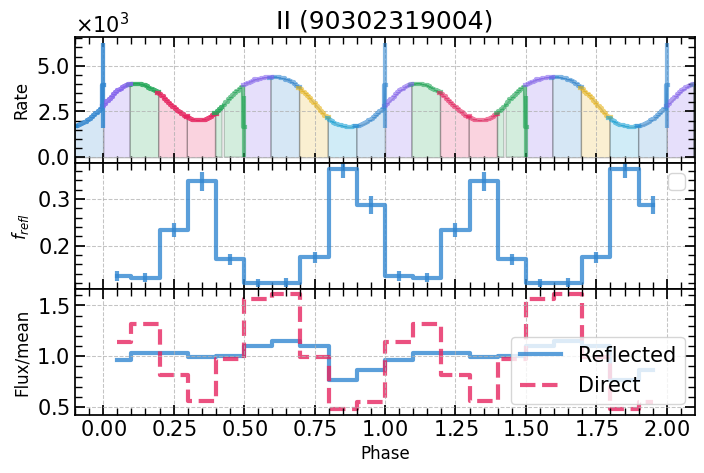

<Figure size 1000x1000 with 0 Axes>

###
Observation 90302319006 loaded successfully
Obs 90302319006: reflected flux  PF = 0.39539098774201725; R = 1.3079229046400869
Obs 90302319006: direct flux  PF = 0.6585516455484433; R = 3.8574011967708914


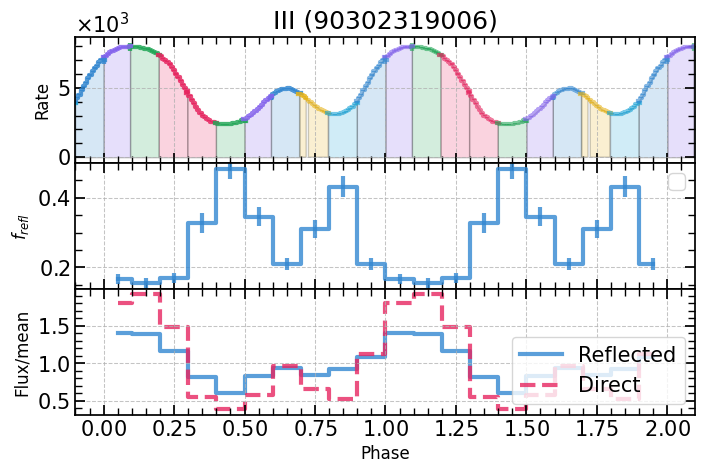

<Figure size 1000x1000 with 0 Axes>

###
Observation 90302319008 loaded successfully
Obs 90302319008: reflected flux  PF = 0.11825948499137208; R = 0.2682410141723268
Obs 90302319008: direct flux  PF = 0.3491441082538401; R = 1.0728768462620284


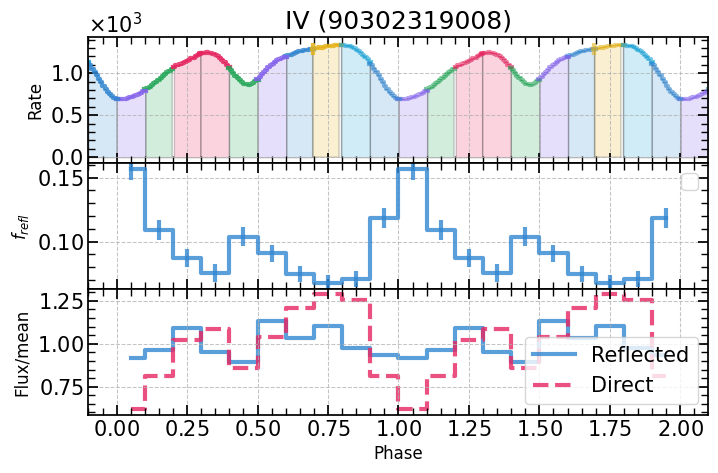

<Figure size 1000x1000 with 0 Axes>

In [5]:
df1, fig1 = plot_results(ObsList_bright[1]);

df2, fig2 = plot_results(ObsList_bright[2]);
 
df3, fig3 = plot_results(ObsList_bright[3]);

fig1.savefig(plot_path+ '/ph-res/high1.pdf')
fig2.savefig(plot_path+ '/ph-res/high2.pdf')
fig3.savefig(plot_path+ '/ph-res/high3.pdf')



Define functions to produce the plots with all spectral parameters

In [6]:

def plot_results_all(ObsID, model = 'relxilllp', plot_refl_flux = True):

    fig = plt.figure(figsize=(6, 8))
    plt.subplots_adjust(hspace=0)
    plt.subplots_adjust(wspace=0)
    rows, cols = 6,  1
    # (rows,cols), (y,x) <- those are coordinates of an axis in subplots
    ax1 = plt.subplot2grid((rows, cols), (0, 0), rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((rows, cols), (1, 0), rowspan=1, colspan=1, sharex = ax1)
    ax3 = plt.subplot2grid((rows, cols), (2, 0), rowspan=1, colspan=1, sharex = ax1)
    ax4 = plt.subplot2grid((rows, cols), (3, 0), rowspan=1, colspan=1, sharex = ax1)
    ax5 = plt.subplot2grid((rows, cols), (4, 0), rowspan=1, colspan=1, sharex = ax1)
    ax6 = plt.subplot2grid((rows, cols), (5, 0), rowspan=1, colspan=1, sharex = ax1)

    nu_obs = NustarObservation(ObsID, nu_path=Nu_path)
    #ph_ave_folder = nu_obs.products_path+'/spe_and_lc'
    ph_res_folder = nu_obs.products_path+'/phase_resolved/'
    os.chdir(ph_res_folder)


    df_ph_res = scan_containers_ph_res(model)
    ph_res_param(df_ph_res, comp = 'relxilllp',     par =  'refl_frac',  ax = ax2, alpha = 0.7, lw = 2, plot = True)

    ph_res_param(df_ph_res, comp = 'relxilllp',     par =  'Ecut',  ax = ax4,  alpha = 0.7, lw = 2,plot = True)
    ph_res_param(df_ph_res, comp = 'relxilllp',     par =  'gamma',  ax = ax5, alpha = 0.7, lw = 2, plot = True)
    ph_res_param(df_ph_res, comp = 'relxilllp',     par =  'norm',  ax = ax6, alpha = 0.7, lw = 2, plot = True)




    
    if plot_refl_flux:
        phases = np.arange(0, 10)
        phases = phases/10+0.05
        phases = np.concatenate((phases, phases+1))#np.tile(phases, 2)
        refl_flux, direct_flux = refl_fluxes[ObsID]
        pf_refl, R_refl = pf_and_relative_var(refl_flux)
        pf_direct, R_direct = pf_and_relative_var(direct_flux)
        
        print(f'Obs {ObsID}: reflected flux  PF = {pf_refl}; R = {R_refl}')
        print(f'Obs {ObsID}: direct flux  PF = {pf_direct}; R = {R_direct}')

        refl_flux = np.tile(refl_flux, 2)/refl_flux.mean()
        direct_flux = np.tile(direct_flux, 2)/direct_flux.mean()
        
        #refl_flux = np.tile(refl_flux, 2)/1e-9
        #direct_flux = np.tile(direct_flux, 2)/1e-9

        ax3.step(phases, refl_flux, ls = '-', color = 'C0', alpha = 0.7, lw = 2, where = 'mid', zorder = -1, label = 'Reflected')
        ax3.step(phases, direct_flux, ls = '--', color = 'C1', alpha = 0.7, lw = 2, where = 'mid', zorder = -1, label = 'Direct')
        #ax3.set_yscale('log')
        #ax3.grid(False)
        #ax3.set_ylabel('Flux \n 10$^{-9}$ erg cm$^{-2}$ s$^{-1}#$', fontsize = 12)
        ax3.set_ylabel('Flux/mean', fontsize = 12)
        ax3.legend(loc = 'lower right')



    fs = 12
    ax1.set_ylabel('Rate 4-79 keV, \n ${\\rm cts}\,{\\rm s}^{-1}$', fontsize = fs)
    ax2.set_ylabel(r'$f_{refl}$', fontsize = fs)
    ax4.set_ylabel(r'$E_{\rm cut}$, keV', fontsize = fs)
    ax5.set_ylabel(r'$\Gamma$', fontsize = fs)
    ax6.set_ylabel(r'norm', fontsize = fs)
    ax3.set_xlabel('Phase', fontsize = fs)
    ax2.legend([])
    #ax4.set_title('')
    ax1.set_title(ObsAlias[ObsID], loc = 'center')



    efolds = glob('*.efold')
    _, phase_colors = nu_obs.plot_efolds_of_bins(prodpath='phase_resolved', efolds_files = efolds , ax_efold = ax1, fig = fig, save = False, legend=False, phase_zero_efold_file='phase_resolved_bin1AB_sr.lc_bary_orb_corr_nphase_128.efold')


    #fig.tight_layout()
    #plt.subplots_adjust(hspace = 0)
    plt.tight_layout()
    plt.show()
    return df_ph_res, fig




###
Observation 90302319004 loaded successfully
Obs 90302319004: reflected flux  PF = 0.20211153579880436; R = 0.5066160118034742
Obs 90302319004: direct flux  PF = 0.5384733271747977; R = 2.3334440190794266


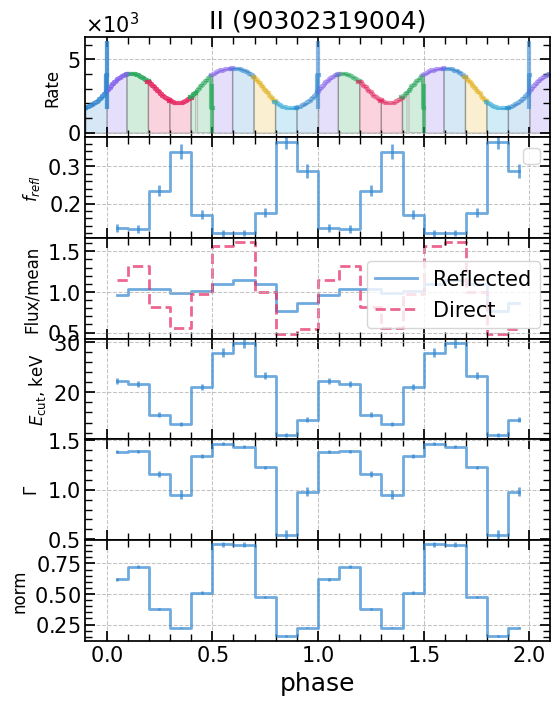

<Figure size 1000x1000 with 0 Axes>

###
Observation 90302319006 loaded successfully
Obs 90302319006: reflected flux  PF = 0.39539098774201725; R = 1.3079229046400869
Obs 90302319006: direct flux  PF = 0.6585516455484433; R = 3.8574011967708914


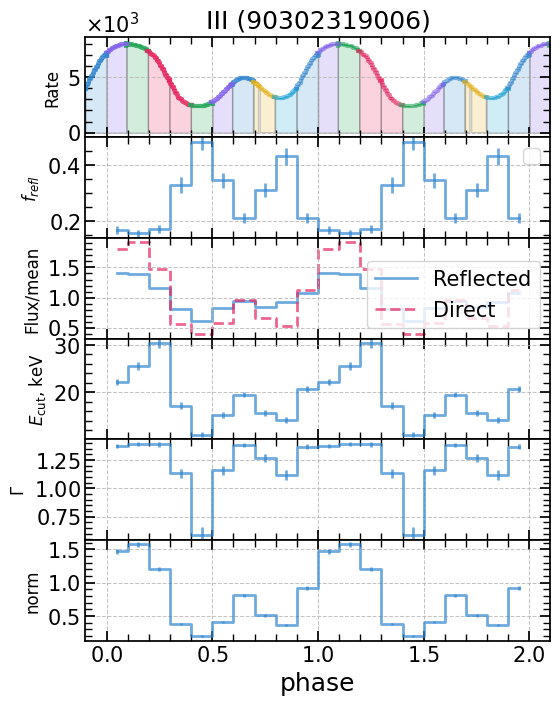

<Figure size 1000x1000 with 0 Axes>

###
Observation 90302319008 loaded successfully
Obs 90302319008: reflected flux  PF = 0.11825948499137208; R = 0.2682410141723268
Obs 90302319008: direct flux  PF = 0.3491441082538401; R = 1.0728768462620284


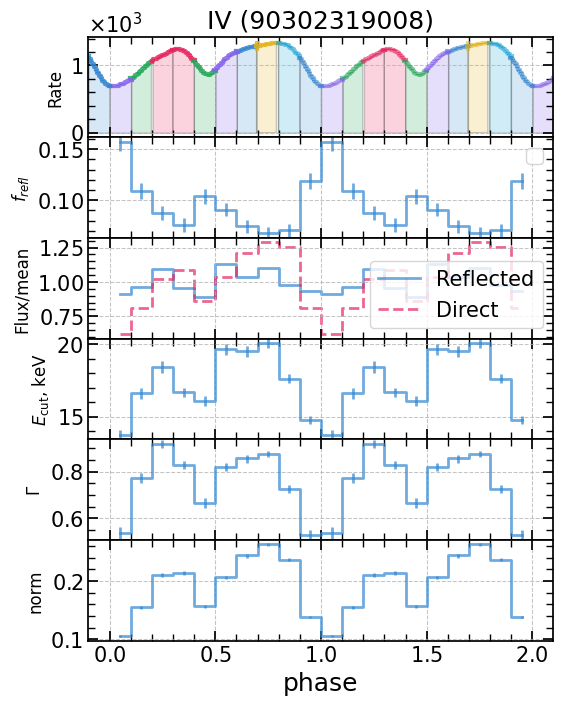

<Figure size 1000x1000 with 0 Axes>

In [7]:
df1, fig1 = plot_results_all(ObsList_bright[1]);

df2, fig2 = plot_results_all(ObsList_bright[2]);

df3, fig3 = plot_results_all(ObsList_bright[3]);

fig1.savefig(plot_path+ '/ph-res/high1_all.pdf')
fig2.savefig(plot_path+ '/ph-res/high2_all.pdf')
fig3.savefig(plot_path+ '/ph-res/high3_all.pdf')




# Tables of phase-resolved results

In [8]:

def val_to_latex(val, lower, upper, frozen = False):

    if type(val)==str:
        if val.startswith('chi2'):
            return val.split(' ', 1)[1]

    if lower==upper==0 and frozen:
        return str(val) +'(fix)'

    err_lo = val - lower
    err_up = upper - val
    k1 = int(np.ceil(-np.log10(err_lo))) #counting the number of digits after the decimal point
    k2 = int(np.ceil(-np.log10(err_up)))
    k = max(k1, k2) #
    if k <= 0:
        k = 0

    my_formatter = f"{{:.{k}f}}"
    str_val = my_formatter.format(val)

    str_err_lo = my_formatter.format(err_lo)
    str_err_up = my_formatter.format(err_up)

    if str_err_lo==str_err_up:
        #return f"{str_val}\\pm{str_err_up}"
        return '$'+str_val + '\\pm' +str_err_up+'$'
    else:
        #return f"{str_val}^{{+{str_err_up}}}_{{-{str_err_lo}}}"
        return '$'+str_val+'^{+'+str_err_up+'}_{-'+str_err_lo+'}$'





In [9]:

def get_ph_res_results(ObsID: str, model = 'relxilllp'):
    os.chdir(f'{analysis_path}out{ObsID}/products/phase_resolved/')
    ph_res_res = scan_containers_ph_res(model_name=model)
    return ph_res_res


In [13]:
for ObsID in ObsList_bright[1:4]:
    ph_res_cutoffpl = get_ph_res_results(ObsID)

    ph_res_cutoffpl['latex_str'] = ph_res_cutoffpl.apply(lambda x: val_to_latex(x['val'], x['error_l'], x['error_u'], frozen=x['frozen']), axis = 1)
    ph_res_cutoffpl_latex = ph_res_cutoffpl[['latex_str']]


    ph_res_cutoffpl_latex = ph_res_cutoffpl_latex.reset_index()
    # ph_res_cutoffpl_latex = ph_res_cutoffpl_latex.pivot(index = ['comp', 'par'], columns = 'phase', values = 'latex_str').fillna('-')
    ph_res_cutoffpl_latex = ph_res_cutoffpl_latex.pivot(columns = ['comp', 'par'], index = 'phase', values = 'latex_str').fillna('-')
    sorting = ['constant', 'phabs', 'relxilllp', 'bbodyrad', 'stat', 'flux']
    #ph_res_cutoffpl_latex = ph_res_cutoffpl_latex.loc[sorting]
    #ph_res_cutoffpl_latex.columns = [ObsAlias[x] for x in ph_res_cutoffpl_latex.columns]

    ph_res_cutoffpl_latex.columns = ['_'.join(col).strip() for col in ph_res_cutoffpl_latex.columns.values]

    ph_res_cutoffpl_latex['refl_flux'] = np.round(refl_fluxes[ObsID][0]/1e-8, 2)
    ph_res_cutoffpl_latex['dir_flux'] = np.round(refl_fluxes[ObsID][1]/1e-8, 1)


    ph_res_cutoffpl_latex = ph_res_cutoffpl_latex[['relxilllp_refl_frac', 'refl_flux',  'dir_flux', 'relxilllp_Ecut', 'relxilllp_gamma', 'relxilllp_norm']]

    
    ph_res_cutoffpl_latex.rename(columns = {'relxilllp_refl_frac': '$f_{\rm refl}$', 'refl_flux': '$F_{\rm refl} (10^{-8} erg s^{-1})$', 'dir_flux': '$f_{\rm dir} (10^{-8} erg s^{-1})$', 'relxilllp_Ecut': '$E_{\rm cut}$', 'relxilllp_gamma': '$\Gamma$', 'relxilllp_norm': 'norm'}, inplace = True)
    print(ObsID)
    print(ph_res_cutoffpl_latex.to_latex(escape=False))


90302319004
\begin{tabular}{llrrlll}
\toprule
{} &   $f_{\rm refl}$ &  $F_{\rm refl} (10^{-8} erg s^{-1})$ &  $f_{\rm dir} (10^{-8} erg s^{-1})$ &         $E_{\rm cut}$ &       $\Gamma$ &                       norm \\
phase &                  &                                      &                                     &                       &                &                            \\
\midrule
0.05  &    $0.14\pm0.01$ &                                 1.46 &                                13.0 &  $22.3^{+0.7}_{-0.6}$ &  $1.38\pm0.02$ &              $0.62\pm0.01$ \\
0.15  &  $0.131\pm0.010$ &                                 1.57 &                                15.0 &          $21.6\pm0.6$ &  $1.38\pm0.02$ &              $0.72\pm0.01$ \\
0.25  &    $0.23\pm0.02$ &                                 1.57 &                                 9.2 &          $15.5\pm0.5$ &  $1.16\pm0.03$ &              $0.38\pm0.01$ \\
0.35  &    $0.34\pm0.02$ &                                 1.50 &        

/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_15651/3588732782.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ph_res_cutoffpl_latex.to_latex(escape=False))
/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_15651/3588732782.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ph_res_cutoffpl_latex.to_latex(escape=False))


90302319008
\begin{tabular}{llrrlll}
\toprule
{} &             $f_{\rm refl}$ &  $F_{\rm refl} (10^{-8} erg s^{-1})$ &  $f_{\rm dir} (10^{-8} erg s^{-1})$ &         $E_{\rm cut}$ &                $\Gamma$ &                       norm \\
phase &                            &                                      &                                     &                       &                         &                            \\
\midrule
0.05  &            $0.157\pm0.009$ &                                 0.33 &                                 3.7 &          $13.8\pm0.3$ &           $0.54\pm0.03$ &            $0.106\pm0.002$ \\
0.15  &            $0.109\pm0.008$ &                                 0.35 &                                 4.8 &  $16.6^{+0.4}_{-0.3}$ &           $0.77\pm0.02$ &            $0.155\pm0.002$ \\
0.25  &            $0.087\pm0.007$ &                                 0.40 &                                 6.1 &          $18.4\pm0.4$ &           $0.92\pm0.02$ &         

/var/folders/hk/rctb6p8n16nbrbnjrwzrc8680000gp/T/ipykernel_15651/3588732782.py:26: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(ph_res_cutoffpl_latex.to_latex(escape=False))
